In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matchms.importing import load_from_mgf
import matchms.filtering as ms_filters
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.similarity import ModifiedCosine
from spec2vec import Spec2Vec
import gensim
import os
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps

In [2]:
np.set_printoptions(threshold=sys.maxsize)
pharma_file_mgf= "GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.mgf"
natural_file_mgf= "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf"
spectrumsPharma = list(load_from_mgf(pharma_file_mgf))
spectrumsNatural = list(load_from_mgf(natural_file_mgf))

In [3]:
spectrumsPharma = spectrumsPharma[:8]
spectrumsNatural = spectrumsNatural[:8]

# Cosine Greedy y Modified Cosine

In [4]:
def metadata_processing(spectrum): 
    spectrum = ms_filters.default_filters(spectrum) 
    spectrum = ms_filters.add_precursor_mz(spectrum) 
    return spectrum 


def peak_processing(spectrum): 
    spectrum = ms_filters.default_filters(spectrum) 
    spectrum = ms_filters.normalize_intensities(spectrum) 
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01) 
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000) 
    return spectrum

In [5]:
numbers_of_peaks_pharma = [len(s.peaks.mz) for s in spectrumsPharma]
numbers_of_peaks_natural = [len(s.peaks.mz) for s in spectrumsNatural]

In [6]:
spectrums_pharma_processed = [metadata_processing(s) for s in spectrumsPharma]
spectrums_pharma_processed = [peak_processing(s) for s in spectrums_pharma_processed]

In [7]:
spectrums_natural_processed = [metadata_processing(s) for s in spectrumsNatural]
spectrums_natural_processed = [peak_processing(s) for s in spectrums_natural_processed]

In [8]:
numbers_of_peaks_pharma_processed = [len(s.peaks.mz) for s in spectrums_pharma_processed]
numbers_of_peaks_natural_processed = [len(s.peaks.mz) for s in spectrums_natural_processed]

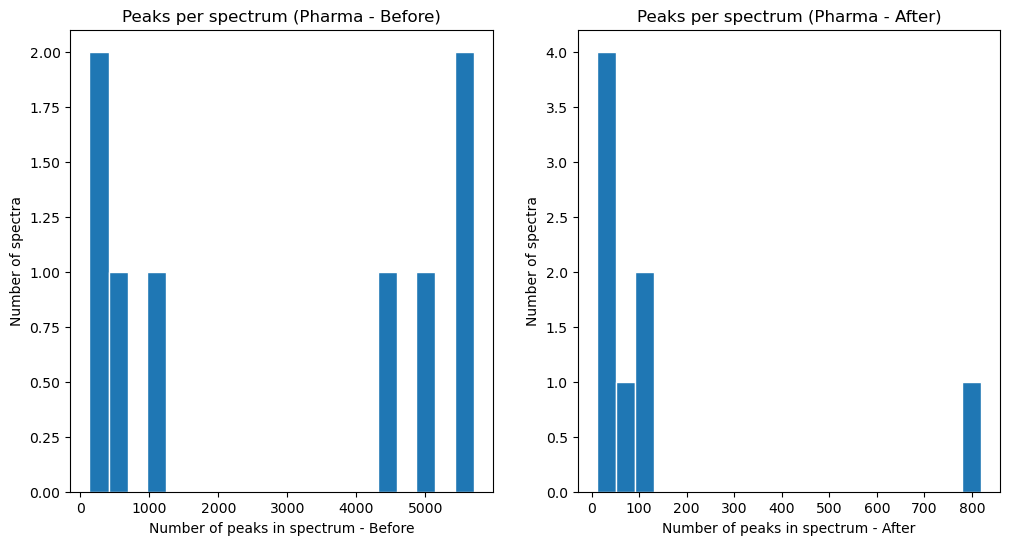

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_pharma, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Pharma - Before)")
ax[1].hist(numbers_of_peaks_pharma_processed, 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Pharma - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

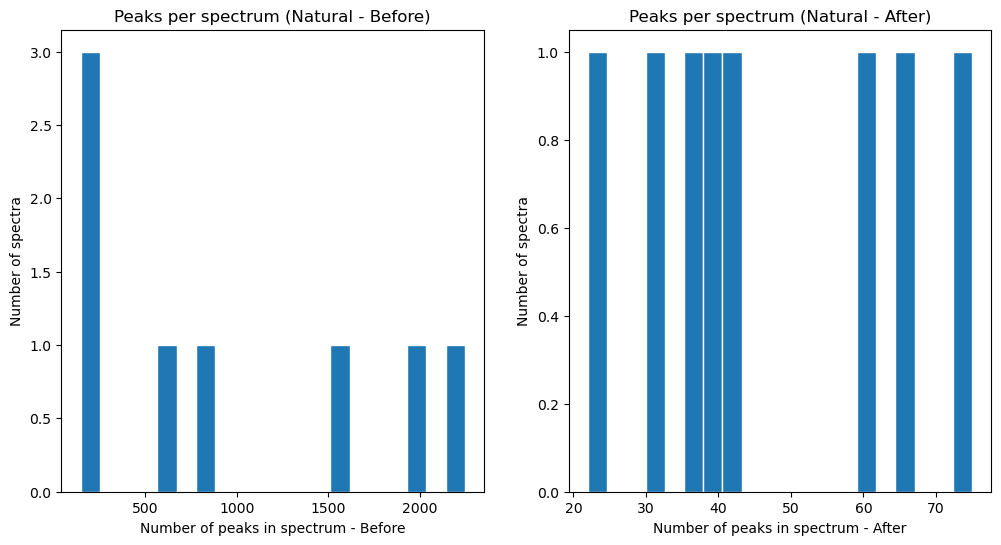

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_natural, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Natural - Before)")
ax[1].hist(numbers_of_peaks_natural_processed, 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Natural - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

In [11]:
similarity_measure_greedy = CosineGreedy(tolerance = 0.005)
similarity_measure_Mod = ModifiedCosine(tolerance = 0.005)

In [12]:
def evaluate_matrix(s1, s2, similarity_measure):

    sim_score = []
    matched_peaks = []
    for sn in s2:
        sim_score_ = []
        matched_peaks_ = []
        for sph in s1:
            score1 = similarity_measure.pair(sph, sn)
            sim_score_.append(score1["score"])
            matched_peaks_.append(score1["matches"])
        sim_score.append(sim_score_)
        matched_peaks.append(matched_peaks_)

    sim_score = np.array(sim_score)
    matched_peaks = np.array(matched_peaks)
    return [sim_score, matched_peaks]

In [13]:
[score_greedy, peaks_greedy] = evaluate_matrix(spectrums_natural_processed[:8], spectrums_pharma_processed[:8], similarity_measure_greedy)

In [14]:
[score_mod, peaks_mod] = evaluate_matrix(spectrums_natural_processed[:8], spectrums_pharma_processed[:8], similarity_measure_Mod)

In [15]:
print(score_mod)

[[5.72453525e-03 2.71872183e-03 4.71874749e-02 2.82127775e-03
  2.35316304e-04 2.71054052e-03 3.15173243e-02 9.08254454e-03]
 [5.87061626e-02 3.27692835e-03 1.32685315e-03 3.43420719e-03
  9.28658225e-04 0.00000000e+00 9.94288613e-03 3.60798215e-02]
 [0.00000000e+00 4.60597267e-04 1.74504133e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.43139164e-01]
 [0.00000000e+00 1.14413999e-04 4.79097995e-01 0.00000000e+00
  2.56461209e-04 0.00000000e+00 3.35239451e-03 0.00000000e+00]
 [0.00000000e+00 3.04943760e-02 1.22054703e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.84895490e-04 0.00000000e+00]
 [8.82935001e-04 3.16863025e-04 2.15891298e-03 4.59595360e-04
  0.00000000e+00 3.06514750e-03 5.13621813e-03 2.54818680e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.52350239e-01]
 [0.00000000e+00 0.00000000e+00 1.16943801e-01 8.52672623e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.02000116e-05]]

In [16]:
score_greedy

array([[0.00528417, 0.00182963, 0.00538961, 0.00264785, 0.00023532,
        0.00141188, 0.03144441, 0.00827844],
       [0.05870616, 0.00309624, 0.00132685, 0.00343421, 0.00092866,
        0.        , 0.00994289, 0.03607982],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.00011441, 0.        , 0.        , 0.00025646,
        0.        , 0.00335239, 0.        ],
       [0.        , 0.02696336, 0.        , 0.        , 0.        ,
        0.        , 0.0002849 , 0.        ],
       [0.00088294, 0.00031686, 0.00215891, 0.0004596 , 0.        ,
        0.00306515, 0.00513622, 0.00025482],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00070757, 0.        ,
        0.        , 0.        , 0.        ]])

In [17]:
peaks_greedy

array([[ 6,  7,  7,  3,  1,  4, 19,  2],
       [ 5,  3,  1,  2,  2,  0,  4, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  3,  0],
       [ 0,  3,  0,  0,  0,  0,  1,  0],
       [ 3,  2,  3,  2,  0,  2,  8,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0]])

In [18]:
peaks_mod

array([[ 8, 12, 13,  4,  1,  5, 20,  5],
       [ 5,  4,  1,  2,  2,  0,  4, 10],
       [ 0,  1,  1,  0,  0,  0,  0,  3],
       [ 0,  1,  5,  0,  1,  0,  3,  0],
       [ 0,  4,  2,  0,  0,  0,  1,  0],
       [ 3,  2,  3,  2,  0,  2,  8,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  3,  3,  0,  0,  0,  1]])

# Spec2Vec

In [19]:
#path_model = os.path.join(os.path.dirname(os.getcwd()),"CEU")
path_model = ""
filename = os.path.join(path_model, "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model")
model = gensim.models.Word2Vec.load(filename)
model.wv.index_to_key[0]

'peak@105.07'

In [20]:
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)

In [21]:
scores = calculate_scores(spectrums_natural_processed, spectrums_pharma_processed, spec2vec_similarity)
scores_spec2vec = scores.scores.to_array()

In [22]:
print(scores_spec2vec)

[[ 0.05383204  0.13972912  0.01189183  0.01418767  0.12244239  0.0416963
   0.02747177  0.09152828]
 [ 0.04759476 -0.00608433  0.03020303 -0.05400686  0.2069743   0.00996051
   0.02839293  0.06775726]
 [ 0.08471002  0.11075825  0.10106716 -0.00953928 -0.00118183  0.05595534
  -0.04899503  0.07607847]
 [ 0.02551789  0.04345199  0.10847599 -0.00646196  0.07537547  0.05875687
  -0.04222722  0.09798684]
 [ 0.14778672  0.11559945  0.10200027  0.14603244  0.14961076  0.07364805
   0.00567533  0.10408052]
 [ 0.05770441 -0.02622728  0.02327867  0.03262255  0.13470561  0.0247862
  -0.05455162  0.05995865]
 [ 0.12566381  0.02026998  0.02702975  0.04626135 -0.05940406 -0.01678315
   0.02961767  0.10017146]
 [ 0.09086893  0.04982435  0.06519651  0.07628391 -0.01145353 -0.01314556
  -0.0452918  -0.00594366]]


# Tanimoto

In [23]:
def FromSmileToFgp(spectrums):
    smiles = []
    for spec in spectrums:
        smiles.append(spec.get("smiles"))

    molecules = []
    for smile in smiles:
        molecules.append(Chem.MolFromSmiles(smile))

    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)

    fgrps = [rdkit_gen.GetFingerprint(molecule) for molecule in molecules]
    return fgrps

In [24]:
fgps_pharma = FromSmileToFgp(spectrums_pharma_processed)
fgps_natural = FromSmileToFgp(spectrums_natural_processed)

In [25]:
def pairwise_similarity(fingerprints1, fingerprints2):
     
    nfgrps1 = len(fingerprints1)
    nfgrps2 = len(fingerprints2)
    similarities = np.zeros((nfgrps1, nfgrps2))

    for i in range(nfgrps1):
            similarity = DataStructs.BulkTanimotoSimilarity(fingerprints1[i], fingerprints2)
            similarities[i, :] = similarity
            similarities[:, i] = similarity

    return similarities

In [26]:
scores_tanimoto = pairwise_similarity(fgps_pharma, fgps_natural)

In [27]:
print(scores_tanimoto)

[[0.17960784 0.30268199 0.31821214 0.23599321 0.34943538 0.29646018
  0.3040774  0.3272328 ]
 [0.30268199 0.28041237 0.35637286 0.19925926 0.39565742 0.29099462
  0.32600259 0.31997328]
 [0.31821214 0.35637286 0.23000762 0.15995763 0.25087352 0.21583986
  0.27272727 0.23679727]
 [0.23599321 0.19925926 0.15995763 0.22749196 0.36319018 0.33114993
  0.32745763 0.31106472]
 [0.34943538 0.39565742 0.25087352 0.36319018 0.36289819 0.2973169
  0.3047619  0.33914306]
 [0.29646018 0.29099462 0.21583986 0.33114993 0.2973169  0.18213866
  0.19097587 0.15200869]
 [0.3040774  0.32600259 0.27272727 0.32745763 0.3047619  0.19097587
  0.30674847 0.30616584]
 [0.3272328  0.31997328 0.23679727 0.31106472 0.33914306 0.15200869
  0.30616584 0.19405941]]


## Errores

In [28]:
def RMSE(X,Y):
    L = len(X)
    return np.sqrt(sum(np.sqrt((X-Y)**2))/L)

In [29]:
def clasify_scores(M):
    h = []
    c = []
    bins = np.arange(0,1.1,0.1)
    M = M.flatten()

    for k in range(0,len(bins)-1):
        aux = np.argwhere((M>=bins[k]) & (M<=bins[k+1]))
        h.append(len(aux))
        c.append(aux)

    s = [h,c]
    return s

In [35]:
s = clasify_scores(scores_tanimoto)
clas = s[1]

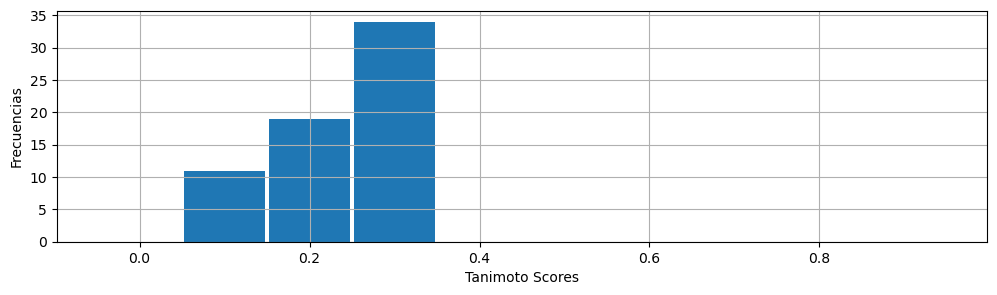

In [42]:
bins = np.arange(0,1,0.1)
fig, ax = plt.subplots(1, 1, figsize=(12,3), dpi = 100)
ax.bar(bins, np.array(s[0]), width=0.095)
ax.set_ylabel("Frecuencias")
ax.set_xlabel("Tanimoto Scores")
ax.grid()
plt.show()

In [43]:
def RMSE_per_bin(X, Y, clas):
    
    X = X.flatten()
    Y = Y.flatten()
    rmse_sd = []
    
    for k in range(len(clas)):

        if len(clas[k]) == 0:
            r = np.nan
            s = np.nan
        else:
            r = RMSE(X[clas[k]],Y[clas[k]])
            s = RMSE(X[clas[k]],r)
            
        rmse_sd.append([r, s])

    return rmse_sd

In [44]:
Tgreedy = RMSE_per_bin(score_greedy, scores_tanimoto, clas)
Tgreedy

[[nan, nan],
 [array([0.42027262]), array([0.64707101])],
 [array([0.50894126]), array([0.71301322])],
 [array([0.57005208]), array([0.75138274])],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan]]

In [45]:
Tmod = RMSE_per_bin(score_mod, scores_tanimoto, clas)
Tmod

[[nan, nan],
 [array([0.43709703]), array([0.63210843])],
 [array([0.51555396]), array([0.70173529])],
 [array([0.57242869]), array([0.74431535])],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan]]

In [46]:
Ts2v = RMSE_per_bin(scores_spec2vec, scores_tanimoto, clas)
Ts2v

[[nan, nan],
 [array([0.4071714]), array([0.62829862])],
 [array([0.47088055]), array([0.65805352])],
 [array([0.51310013]), array([0.66778472])],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan]]